Wave Analysis

Import Libraries

In [1]:
from mne.preprocessing.nirs import optical_density
from itertools import compress

import pandas as pd
from itertools import compress
from collections import defaultdict
from copy import deepcopy
from pprint import pprint

# Import MNE processing
import mne
from mne.viz import plot_compare_evokeds
from mne import Epochs, events_from_annotations, set_log_level

# Import MNE-NIRS processing
import mne_nirs
from mne_nirs.channels import get_long_channels, get_short_channels
from mne_nirs.channels import picks_pair_to_idx as p2idx
from mne_nirs.datasets import fnirs_motor_group
from mne.preprocessing.nirs import beer_lambert_law, optical_density,\
    temporal_derivative_distribution_repair, scalp_coupling_index
from mne_nirs.signal_enhancement import (enhance_negative_correlation,
                                         short_channel_regression)

# Import MNE-BIDS processing
from mne_bids import BIDSPath, read_raw_bids

# Import StatsModels
import statsmodels.formula.api as smf

# Import Plotting Library
import matplotlib.pyplot as plt
import lets_plot
from lets_plot import *

# Imports libraries related to GLM Ananlysis
import h5py
from scipy import interpolate
import numpy as np
from mne_nirs.experimental_design import make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix
from mne_nirs.statistics import run_glm
from mne import read_evokeds

from mne_bids import BIDSPath



Import Data and make Conversions

In [2]:
fname = r"C:\Users\dalto\Downloads\project\sourcedata_lm\sub-07\nirs\sub-07_task-task_nirs.snirf"

raw_intensity = mne.io.read_raw_snirf(
    fname, preload=True, optode_frame="mri"
)  # reads snirf file and stores into 'raw' data type

raw_intensity.resample(0.7)  # resample the raw intensity data at 0.7 Hz

raw_od = optical_density(
    raw_intensity
)  # converts nirs 'raw' data into 'raw' optical density data


condition = "Meaningful"
leg_list = ["Oxyhaemoglobin", "Oxyhaemoglobin Range","Start of Epoch","Deoxyhaemoglobin","Deoxyhaemoglobin Range"]  #stores values to go in waveform analysis legend
cond_list = ["Control", "Speech"]  # list of the potential conditions


Loading C:\Users\dalto\Downloads\project\sourcedata_lm\sub-07\nirs\sub-07_task-task_nirs.snirf


Reading 0 ... 6041  =      0.000 ...  1187.661 secs...


Establish function to perform analysis on each data point after the trigger

In [3]:
def individual_analysis(bids_path):
    # Read data with annotations in BIDS format
    raw_intensity = mne.io.read_raw_snirf(
        fname=bids_path, verbose=False, optode_frame="mri"
    )

    # Rename annotations
    raw_intensity.annotations.delete(
        raw_intensity.annotations.description == '15'
    )  # Delete unwanted annotation
    # raw_intensity.annotations.rename(
    #     {'1': 'Speech', '2': 'No Speech'}
    # )  # Rename annotations to meaningful labels
    # raw_intensity.annotations.rename(
    #     {'Meaningful6': 'Button'}
    # )  # Correct a specific annotation label

    # Convert signal to optical density and determine bad channels
    raw_od = optical_density(raw_intensity)  # Convert intensity data to optical density
    sci = scalp_coupling_index(
        raw_od, h_freq=1.35, h_trans_bandwidth=0.1
    )  # Calculate scalp coupling index
    raw_od.info["bads"] = list(
        compress(raw_od.ch_names, sci < 0.7)
    )  # Identify and mark channels with poor scalp coupling
    raw_od.interpolate_bads()  # Interpolate bad channels

    # Downsample and apply signal cleaning techniques
    raw_od.resample(0.8)  # Downsample the data
    raw_od = temporal_derivative_distribution_repair(
        raw_od
    )  # Apply temporal derivative distribution repair
    raw_od = short_channel_regression(
        raw_od
    )  # Perform short channel subtraction

    # Convert to haemoglobin and filter
    raw_haemo = beer_lambert_law(
        raw_od, ppf=.1
    )  # Apply the Beer-Lambert Law to convert to haemoglobin
    raw_haemo = raw_haemo.filter(
        0.02, 0.3, h_trans_bandwidth=0.1, l_trans_bandwidth=0.01, verbose=False
    )  # Apply bandpass filtering

    # Apply further data cleaning techniques and extract epochs
    raw_haemo = get_long_channels(
        raw_haemo, min_dist=0.015, max_dist=0.045
    )  # Filter out short channels
    events, event_dict = mne.events_from_annotations(
        raw_haemo, verbose=False
    )  # Extract events and create event dictionary
    epochs = Epochs(
        raw_haemo,
        events,
        event_id=event_dict,
        ###########################  MODIFY THIS FOR EACH EXPERIMENT #############################
        tmin=-5,  # Set the minimum time before the onset of the signal for each epoch
        tmax=12,  # Set the maximum time after the onset of the signal for each epoch
        ########################################  END  ###########################################
        reject=dict(hbo=100e-6),  # Set the peak-to-peak amplitude rejection criteria per epoch
        reject_by_annotation=True,  # Reject epochs based on annotations
        proj=False,
        baseline=(None, 0),
        detrend=1,
        preload=True,
        verbose=True
    )  # Create epochs

    return raw_haemo, epochs


Evoked Response Analysis for Multiple Subjects

In [4]:
all_evokeds = defaultdict(list)

for sub in range(1, 11):  # change range values to specify the number of subject recordings to be analyzed
#for sub in [7, 8, 9, 10, 11]:     
    bids_path = BIDSPath(subject="%02d" % sub ,
                        #  session="01", 
                         datatype="nirs",
                         task='task',
                         suffix='nirs',
                         root= r"C:\Users\dalto\Downloads\project\sourcedata_lm",
                         extension= ".snirf")

    
    # Analyse data and return both ROI and channel results
    raw_haemo, epochs = individual_analysis(bids_path)

    # Save individual-evoked participant data along with others in all_evokeds
    for cidx, condition in enumerate(epochs.event_id):
        all_evokeds[condition].append(epochs[condition].average())

Reading 0 ... 5829  =      0.000 ...  1145.981 secs...
Interpolating bad channels
    Automatic origin fit: head of radius 90.8 mm
Not setting metadata
42 matching events found
Setting baseline interval to [-5.0, 0.0] sec
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 42 events and 15 original time points ...
    Rejecting  epoch based on HBO : ['S4_D1 hbo', 'S5_D5 hbo']
    Rejecting  epoch based on HBO : ['S4_D1 hbo']
    Rejecting  epoch based on HBO : ['S4_D1 hbo', 'S4_D3 hbo']
    Rejecting  epoch based on HBO : ['S4_D1 hbo']
    Rejecting  epoch based on HBO : ['S4_D1 hbo']
    Rejecting  epoch based on HBO : ['S4_D1 hbo', 'S4_D3 hbo']
    Rejecting  epoch based on HBO : ['S4_D1 hbo', 'S4_D3 hbo']
    Rejecting  epoch based on HBO : ['S4_D1 hbo', 'S4_D3 hbo']
9 bad epochs dropped


C:\Users\dalto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\dalto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
C:\Users\dalto\AppData\Local\Temp\ipykernel_12988\2774657211.py:19: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  all_evokeds[condition].append(epochs[condition].average())


Reading 0 ... 6250  =      0.000 ...  1228.750 secs...
Interpolating bad channels
    Automatic origin fit: head of radius 90.8 mm
Not setting metadata
42 matching events found
Setting baseline interval to [-5.0, 0.0] sec
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 42 events and 15 original time points ...
    Rejecting  epoch based on HBO : ['S9_D8 hbo', 'S12_D8 hbo']
2 bad epochs dropped
Reading 0 ... 6022  =      0.000 ...  1183.925 secs...
Interpolating bad channels
    Automatic origin fit: head of radius 90.8 mm
Not setting metadata
42 matching events found
Setting baseline interval to [-5.0, 0.0] sec
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 42 events and 15 original time points ...
1 bad epochs dropped
Reading 0 ... 6124  =      0.000 ...  1203.978 secs...
Interpolating bad channels
    Automatic origin fit: head of radius 90.8 mm
Not setting metadata
42 matching events found
Setting baseline interval to [-5.0, 0

Region of Interest Declaration

In [6]:
##########################################################
# ⚡️⚡️⚡️ MODIFY THIS SECTION FOR EACH EXPERIMENT ⚡️⚡️⚡️
##########################################################

# Define a dictionary of ROI lists
roi_lists = {
    "Left_IFG": [[1,1], [2,1], [3,1], [4,1], [3,2], [4,2]],
    "Left_HG": [[5,3], [5,4], [5,5], [6,3], [6,4], [6,5]],
    "Left_PT": [[6,6], [6,7], [7,5], [7,7], [8,6], [8,7]],
    "Right_IFG": [[9,8], [10,8], [11,8], [11,9], [12,8], [12,9]],
    "Right_HG": [[13,10], [13,11], [13,12], [14,10], [14,11], [14,12]],
    "Right_PT": [[14,13], [14,14], [15,12], [15,14], [16,13], [16,14]]
}

roi_lists = {
    'Left_IFG' : [[1,1], [2,1], [3,1], [4,1], [3,2], [4,2]],
    'Left_HG' : [[5,3], [5,4], [5,5], [6,3], [6,4], [6,5]],
    'Left_PT' :[[6,6], [6,7], [7,5], [7,7],  [8,6], [8,7]],
    'Right_IFG' :  [[9,8], [10,8], [11,8], [11,9], [12,8], [12,9]],
    'Right_HG' : [[13,10], [13,11], [13,12], [14,10], [14,11], [14,12]],
    'Right_PT' : [[14,13], [14,14], [15,12], [15,14], [16,13], [16,14]]
}


# Assign the contents of each ROI list to separate variables
Left_IFG = roi_lists['Left_IFG']
Left_HG = roi_lists['Left_HG']
Left_PT = roi_lists['Left_PT']
Right_IFG = roi_lists['Right_IFG']
Right_HG = roi_lists['Right_HG']
Right_PT = roi_lists['Right_PT']

Pair ROI to data

In [7]:
# Name ROIs and pair each list to the raw type haemo data
rois = dict(Left_IFG=p2idx(raw_haemo, [[1,1], [2,1], [3,1], [4,1], [3,2], [4,2]],
                      on_missing='warning'),
            Left_HG=p2idx(raw_haemo, [[5,3], [5,4], [5,5], [6,3], [6,4], [6,5]],
                          on_missing='warning'),

            Left_PT=p2idx(raw_haemo, [[6,6], [6,7], [7,5], [7,7],  [8,6], [8,7]],
                          on_missing='warning'),
            Right_HG=p2idx(raw_haemo, [[13,10], [13,11], [13,12], [14,10], [14,11], [14,12]],
                           on_missing='warning'),
            Right_PT=p2idx(raw_haemo, [[14,13], [14,14], [15,12], [15,14], [16,13], [16,14]],
                           on_missing='warning'),
            Right_IFG=p2idx(raw_haemo, [[9,8], [10,8], [11,8], [11,9], [12,8], [12,9]],
                              on_missing='warning'))

Create Matrix to Frame Data Within

In [8]:
df = pd.DataFrame(columns=['ID', 'ROI', 'Chroma', 'Condition', 'Value']) #creates pandas dataframe to hold specified data
# PRINTS AMPLITUDES OF EVOKED RESPONSES FOR EACH TRIGGER AT EACH ROI
for idx, evoked in enumerate(all_evokeds):
    for id, subj_data in enumerate(all_evokeds[evoked]):
        for roi in rois:
            for chroma in ["hbo", "hbr"]:
                # Get subject ID
                subj_id = id

                # Extract data for the specified ROI and chroma
                data = deepcopy(subj_data).pick(picks=rois[roi]).pick(chroma)

                # Calculate the mean value of the data within a specified time range
                value = data.crop(tmin=3.0, tmax=8.0).data.mean() * 1.0e6

                # Append metadata and extracted feature to the dataframe
                new = {'ID': subj_id, 'ROI': roi, 'Chroma': chroma, 'Condition': evoked, 'Value': value}
                new_df = pd.DataFrame(new, index=[0])
                df = pd.concat([df, new_df])
# You can export the dataframe for analysis in your favorite stats program
# df.to_csv("stats-export-waveform.csv")

Print Regions of Interest

In [10]:
display(df)

print("\n-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-= Regions of Interest -=-=-=-=-=-=-=--=-=-=-=-=-=-=-=-=-=-=-=-")
for name, content in roi_lists.items():
    print(f'{name}: {content}')
print("-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=--=-=-=-=-=-=-=-=-=-=-=-=-=-=-=--=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-\n")

,ID,ROI,Chroma,Condition,Value
0,0,Left_IFG,hbo,1.0,-6.814094
0,0,Left_IFG,hbr,1.0,1.881337
0,0,Left_HG,hbo,1.0,4.019052
0,0,Left_HG,hbr,1.0,-0.041192
0,0,Left_PT,hbo,1.0,7.221635
...,...,...,...,...,...
0,9,Right_HG,hbr,2.0,1.200807
0,9,Right_PT,hbo,2.0,-0.687794
0,9,Right_PT,hbr,2.0,0.302069
0,9,Right_IFG,hbo,2.0,-1.036784



-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-= Regions of Interest -=-=-=-=-=-=-=--=-=-=-=-=-=-=-=-=-=-=-=-
Left_IFG: [[1, 1], [2, 1], [3, 1], [4, 1], [3, 2], [4, 2]]
Left_HG: [[5, 3], [5, 4], [5, 5], [6, 3], [6, 4], [6, 5]]
Left_PT: [[6, 6], [6, 7], [7, 5], [7, 7], [8, 6], [8, 7]]
Right_IFG: [[9, 8], [10, 8], [11, 8], [11, 9], [12, 8], [12, 9]]
Right_HG: [[13, 10], [13, 11], [13, 12], [14, 10], [14, 11], [14, 12]]
Right_PT: [[14, 13], [14, 14], [15, 12], [15, 14], [16, 13], [16, 14]]
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=--=-=-=-=-=-=-=-=-=-=-=-=-=-=-=--=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-



combining channels using "mean"


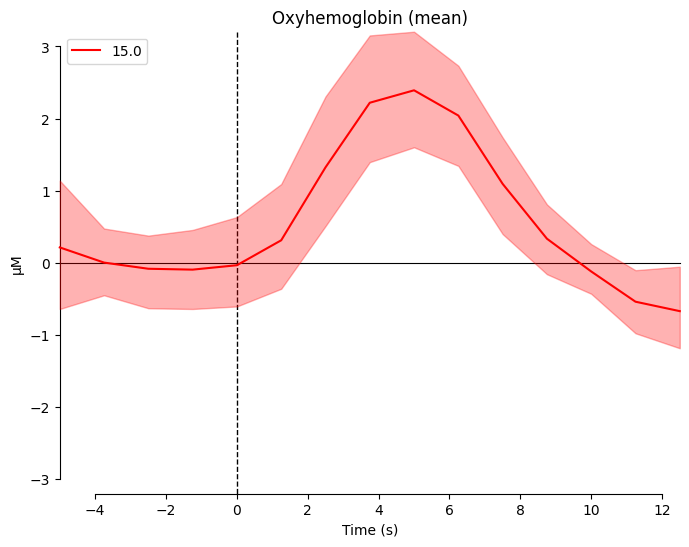

combining channels using "mean"


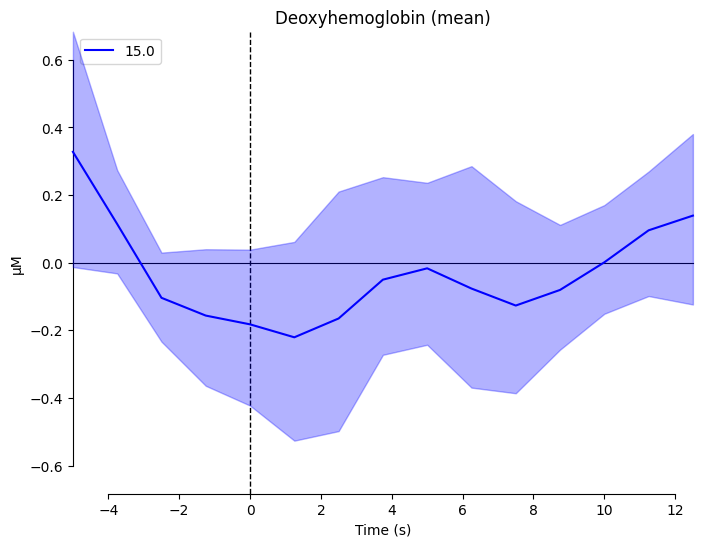

In [32]:
# display(all_evokeds)

for pick, color in zip(['hbo','hbr'],['r','b']):
    plot_compare_evokeds({evoked:all_evokeds['1.0']},combine='mean',picks=pick,colors=[color])
plt.show()

Plot Concentrations Against Time for Each Trigger

{'1.0': [<Evoked | '1.0' (average, N=16), -5 – 12.5 sec, baseline -5 – 0 sec, 76 ch, ~105 kB>, <Evoked | '1.0' (average, N=20), -5 – 12.5 sec, baseline -5 – 0 sec, 76 ch, ~105 kB>, <Evoked | '1.0' (average, N=20), -5 – 12.5 sec, baseline -5 – 0 sec, 76 ch, ~105 kB>, <Evoked | '1.0' (average, N=16), -5 – 12.5 sec, baseline -5 – 0 sec, 76 ch, ~105 kB>, <Evoked | '1.0' (average, N=20), -5 – 12.5 sec, baseline -5 – 0 sec, 76 ch, ~105 kB>, <Evoked | '1.0' (average, N=16), -5 – 12.5 sec, baseline -5 – 0 sec, 76 ch, ~105 kB>, <Evoked | '1.0' (average, N=20), -5 – 12.5 sec, baseline -5 – 0 sec, 76 ch, ~105 kB>, <Evoked | '1.0' (average, N=20), -5 – 12.5 sec, baseline -5 – 0 sec, 76 ch, ~105 kB>, <Evoked | '1.0' (average, N=20), -5 – 12.5 sec, baseline -5 – 0 sec, 76 ch, ~105 kB>, <Evoked | '1.0' (average, N=15), -5 – 12.5 sec, baseline -5 – 0 sec, 76 ch, ~105 kB>], '15.0': [<Evoked | '' (average, N=0), -5 – 12.5 sec, baseline -5 – 0 sec, 76 ch, ~105 kB>, <Evoked | '15.0' (average, N=1), -5 – 1

ValueError: Some of the values  to be plotted are NaN.

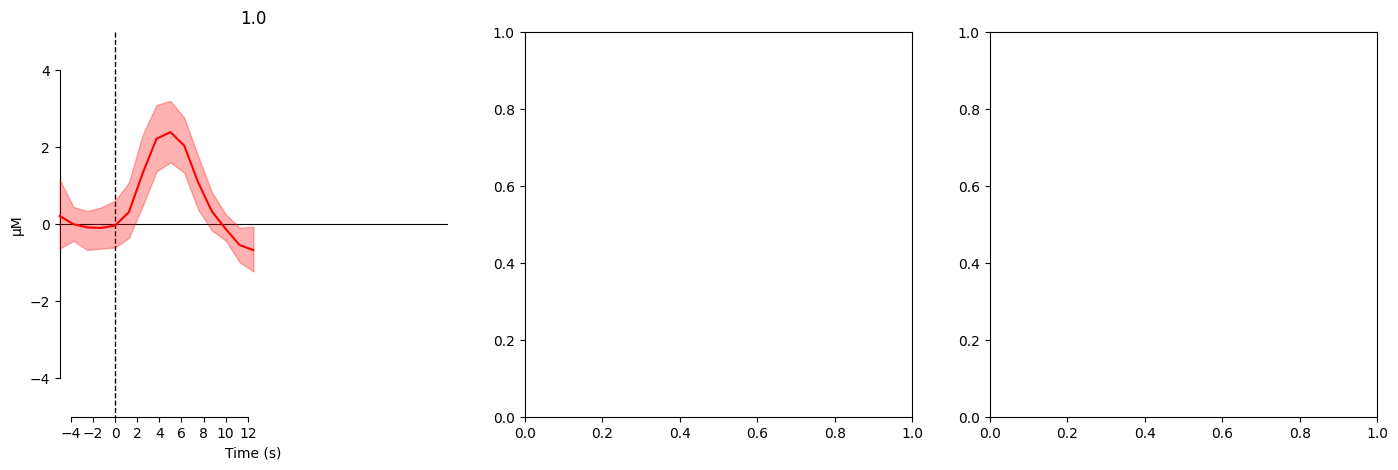

In [21]:
# Specify the figure size and limits per chromophore
fig, axes = plt.subplots(nrows=1, ncols=len(all_evokeds), figsize=(17, 5))
lims = dict(hbo=[-5, 5], hbr=[-5, 5])  # Set the scale limits for each chromophore
all_evokeds = {key: value for key, value in all_evokeds.items() if value is not None}
# (dict(all_evokeds['1.0'])).dropna()
print(all_evokeds)

for (pick, color) in zip(['hbo', 'hbr'], ['r', 'b']):
    for idx, evoked in enumerate(all_evokeds):
        # Plot the average evoked response for each condition and chromophore
        print('puss')
        if evoked != 'NaN':
            plot_compare_evokeds({evoked: all_evokeds[evoked]}, combine='mean',
                                picks=pick, axes=axes[idx], show=False,
                                colors=[color], legend=False, ylim=lims, ci=0.95,
                                show_sensors=idx == 2)
            
            axes[idx].set_title('{}'.format(evoked))  # Set the title for each subplot
            axes[idx].set_xlim(-5,30)
        
axes[0].legend(leg_list, loc='upper right')  # Update the legend labels
plt.show()  # Display the plot

Plots Concentrations Across For Each Region and Trigger

combining channels using "mean"
combining channels using "mean"


ValueError: Some of the values  to be plotted are NaN.

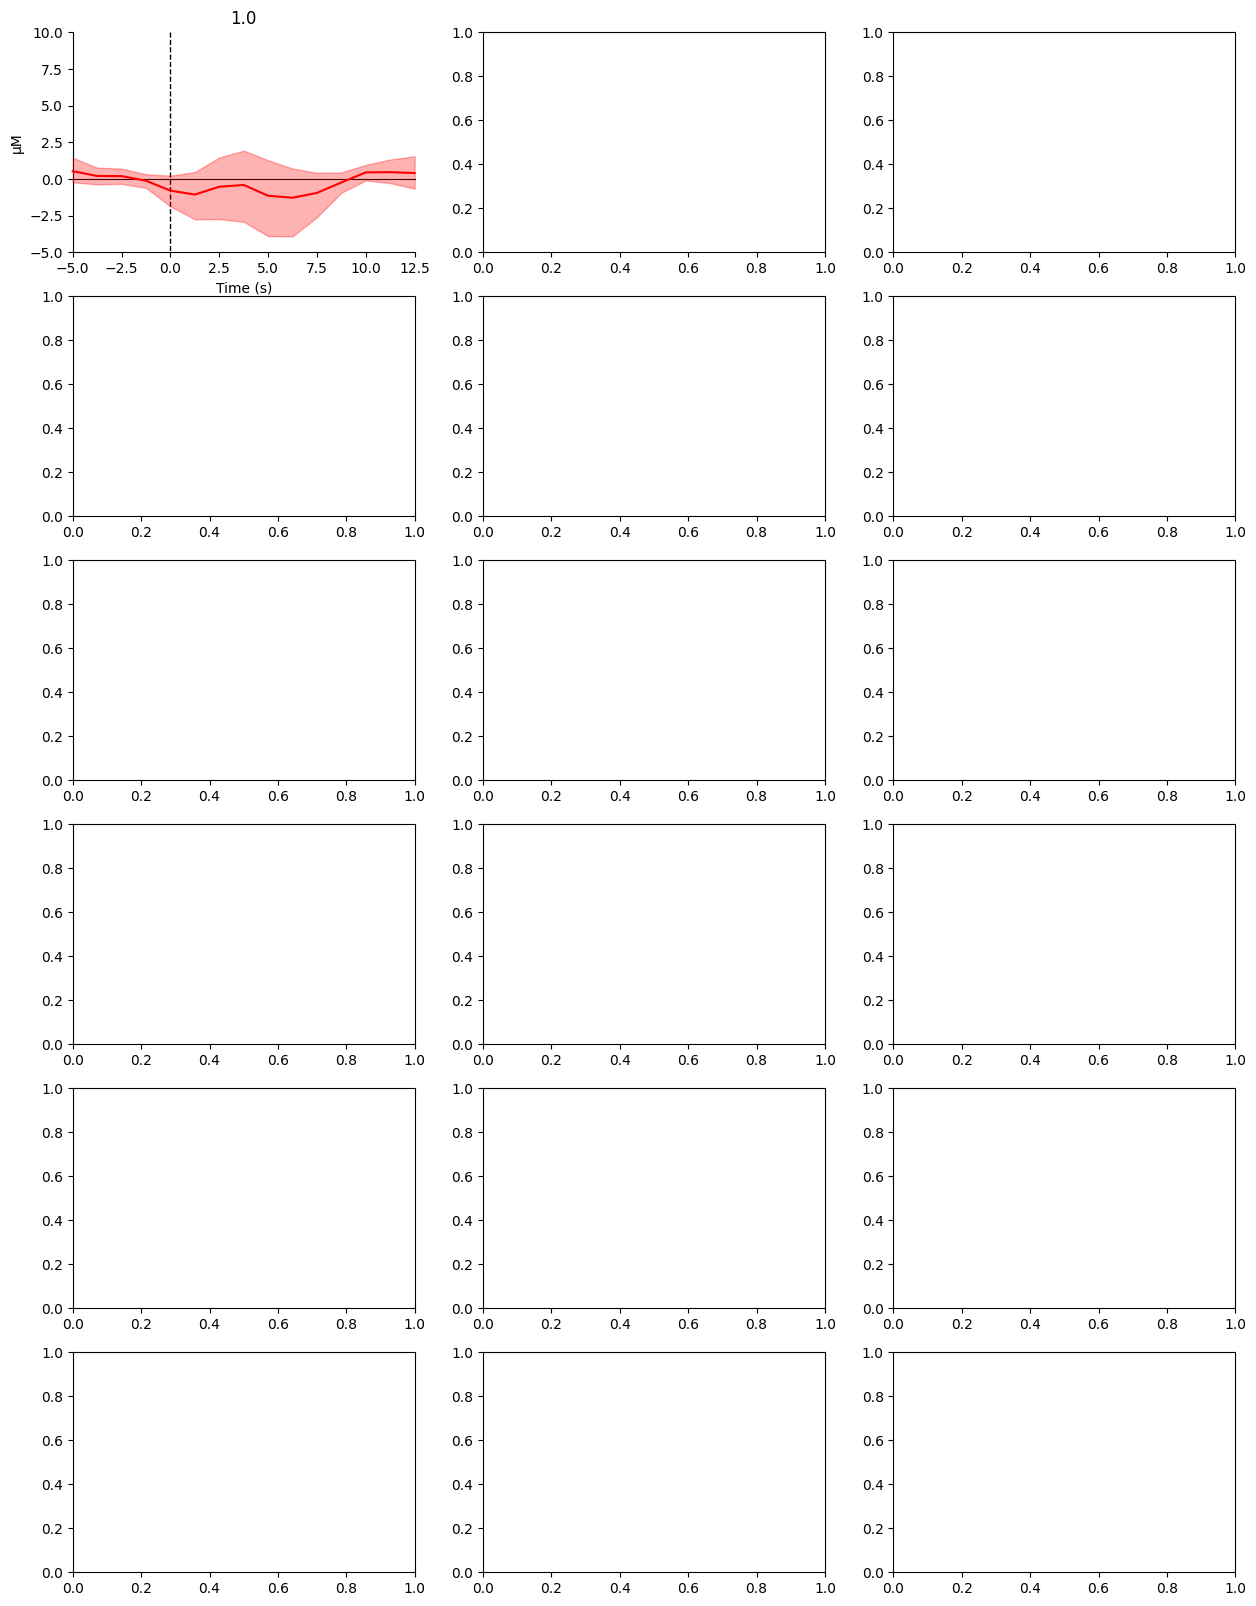

In [22]:
# Adjust the code below to fit your unique ROIs
# Specify the figure size and limits per chromophore.
fig, axes = plt.subplots(nrows=len(rois), ncols=len(all_evokeds),
                        figsize=(15, 20))

lims = dict(hbo=[-5, 10], hbr=[-5, 10])  # Set the scale limits for each chromophore

for (pick, color) in zip(['hbo', 'hbr'], ['r', 'b']):
    for ridx, roi in enumerate(rois):
        for cidx, evoked in enumerate(all_evokeds):
            if pick == 'hbr':
                picks = rois[roi][1::2]  # Select only the hbr channels
            else:
                picks = rois[roi][0::2]  # Select only the hbo channels

            # Plot the average evoked response for each condition and chromophore
            plot_compare_evokeds({evoked: all_evokeds[evoked]}, combine='mean',
                                picks=picks, axes=axes[ridx, cidx],
                                show=False, colors=[color], legend=False,
                                ylim=lims, ci=0.95, show_sensors=cidx == 2)
            axes[0, cidx].set_title(f"{evoked}")  # Set the title for the first row
            axes[1, cidx].set_title("")  # Empty title for the second row
            axes[2, cidx].set_title("")  # Empty title for the third row
            axes[3, cidx].set_title("")  # Empty title for the fourth row

        axes[ridx, 0].set_ylabel(f"{roi}\nChromophore (ΔμMol)")  # Set the y-label for each row

axes[0, 0].legend(leg_list)  # Add the legend
plt.show()  # Display the plot

Print the Evoked Amplitude Data into the Console

In [ ]:
# Print out the first entries in the dataframe
df.head()
pprint(df)

   ID        ROI Chroma Condition     Value
0   0   Left_IFG    hbo       1.0 -6.814094
0   0   Left_IFG    hbr       1.0  1.881337
0   0    Left_HG    hbo       1.0  4.019052
0   0    Left_HG    hbr       1.0 -0.041192
0   0    Left_PT    hbo       1.0  7.221635
.. ..        ...    ...       ...       ...
0   9   Right_HG    hbr       2.0  1.200807
0   9   Right_PT    hbo       2.0 -0.687794
0   9   Right_PT    hbr       2.0  0.302069
0   9  Right_IFG    hbo       2.0 -1.036784
0   9  Right_IFG    hbr       2.0  1.599855

[360 rows x 5 columns]


Plot the Evoked Amplitude Data

In [ ]:
LetsPlot.setup_html()

# Plots individual results by plotting evoked amplitudes for each trigger
ggplot(df.query("Chroma == 'hbo'"),
       aes(x='Condition', y='Value', color='ID', shape='ROI')) \
    + geom_hline(y_intercept=0, linetype="dashed", size=1) \
    + geom_point(size=5) \
    + scale_shape_manual(values=[16, 17]) \
    + ggsize(800, 300)

Compare Conditions

In [ ]:
# Compare conditions within an ROI

# Filter input data based on conditions, chromophore, and ROI
input_data = df.query("Condition in ['Control', 'Meaningful']")  # Filter conditions
input_data = input_data.query("Chroma in ['hbo']")  # Filter chromophore
input_data = input_data.query("ROI in ['IFG']")  # Filter ROI

# Fit mixed-effects model with groups based on ID
roi_model = smf.mixedlm("Value ~ Condition", input_data,
                        groups=input_data["ID"]).fit()

# Print the summary of the fitted model
pprint(roi_model.summary())

ValueError: negative dimensions are not allowed

GLM Analysis initializations

In [ ]:
####################################################
# ⚡️⚡️⚡️        GLM ANALYSIS SET UP        ⚡️⚡️⚡️
####################################################
raw_intensity.annotations.rename({'1': 'Meaningful',  # Rename annotation '1' to 'Meaningful'
                                  '2': 'Anomalous',  # Rename annotation '2' to 'Anomalous'
                                  '16': 'Button',  # Rename annotation '16' to 'Button'
                                  '3': 'Control'})  # Rename annotation '3' to 'Control'

raw_intensity.annotations.rename({'Meaningful6': 'Button',  # Rename annotation 'Meaningful6' to 'Button'
                                  'Meaningful5': 'Button'})  # Rename annotation 'Meaningful5' to 'Button'

raw_intensity.annotations.delete(raw_intensity.annotations.description == 'Button')  # Delete annotations with description 'Button'

raw_intensity.annotations.set_durations(10)  # Set the duration of all annotations to 10 seconds

raw_od = mne.preprocessing.nirs.optical_density(raw_intensity)  # Convert raw intensity data to optical density data
raw_haemo = mne.preprocessing.nirs.beer_lambert_law(raw_od, ppf=.1)  # Apply the Beer-Lambert law to convert optical density to haemoglobin concentrations

short_chs = get_short_channels(raw_haemo)  # Get short channels from the haemoglobin data
long_chs = get_long_channels(raw_haemo)  # Get long channels from the haemoglobin data

Create Design Matrix

In [ ]:

design_matrix = make_first_level_design_matrix(raw_haemo,
                                               drift_model='cosine',
                                               high_pass=0.015,  # Specify the high-pass filter cutoff frequency
                                               hrf_model='spm',
                                               stim_dur=10)  # Specify the duration of the stimulation

design_matrix["ShortHbO"] = np.mean(short_chs.copy().pick(
                                    picks="hbo").get_data(), axis=0)  # Compute the mean of short channels' HbO data and add it to the design matrix

design_matrix["ShortHbR"] = np.mean(short_chs.copy().pick(
                                    picks="hbr").get_data(), axis=0)  # Compute the mean of short channels' HbR data and add it to the design matrix


Matching WINGS signals to NIRS data

In [ ]:
# Match WINGS auxiliary signals to NIRS data samples
dat = h5py.File(fname, 'r')  # Open the HDF5 file specified by 'fname'

for n in range(1, 24):  # Iterate over the range from 1 to 23 (inclusive)
    aux = np.array(dat.get(f'nirs/aux{n}/dataTimeSeries'))  # Retrieve auxiliary data from the HDF5 file
    aux_time = np.array(dat.get(f'nirs/aux{n}/time'))  # Retrieve time information for the auxiliary data
    aux_data_interp = interpolate.interp1d(aux_time, aux, axis=0, bounds_error=False, fill_value='extrapolate')  # Perform interpolation of the auxiliary data to match the time points of the raw intensity data
    aux_data_matched_to_fnirs = aux_data_interp(raw_intensity.times)  # Match the interpolated auxiliary data to the time points of the raw intensity data
    design_matrix[np.array(dat.get(f'nirs/aux{n}/name'))[0].decode()] = aux_data_matched_to_fnirs  # Add the auxiliary data to the design matrix with the corresponding name

glm_est = run_glm(raw_haemo, design_matrix)  # Perform the GLM estimation using the raw haemoglobin data and the design matrix

Visualizing GLM

In [ ]:
subjects_dir = mne.datasets.sample.data_path() / 'subjects'  # Set the path to the subjects directory
glm_est.copy().surface_projection(condition=condition, view="dorsal", chroma="hbo", subjects_dir=subjects_dir)  # Copy the GLM estimation results and visualize the surface projection of a specific condition, chromophore, and view using the specified subjects directory

Plot Short Channels

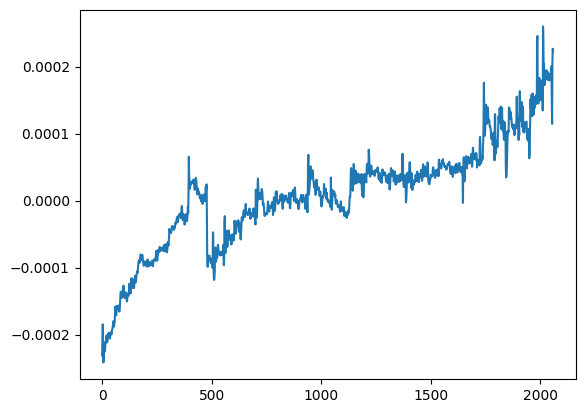

In [ ]:
# Visualize a single WINGS auxiliary signal within the design matrix (scale will change depending on if it's raw, mean-normalized, or z-scores)
plt.plot(design_matrix['ShortHbO'])  # Plot the values of the 'ShortHbO' auxiliary signal in the design matrix
plt.show()  # Show the plot

Plotting Design Matrix

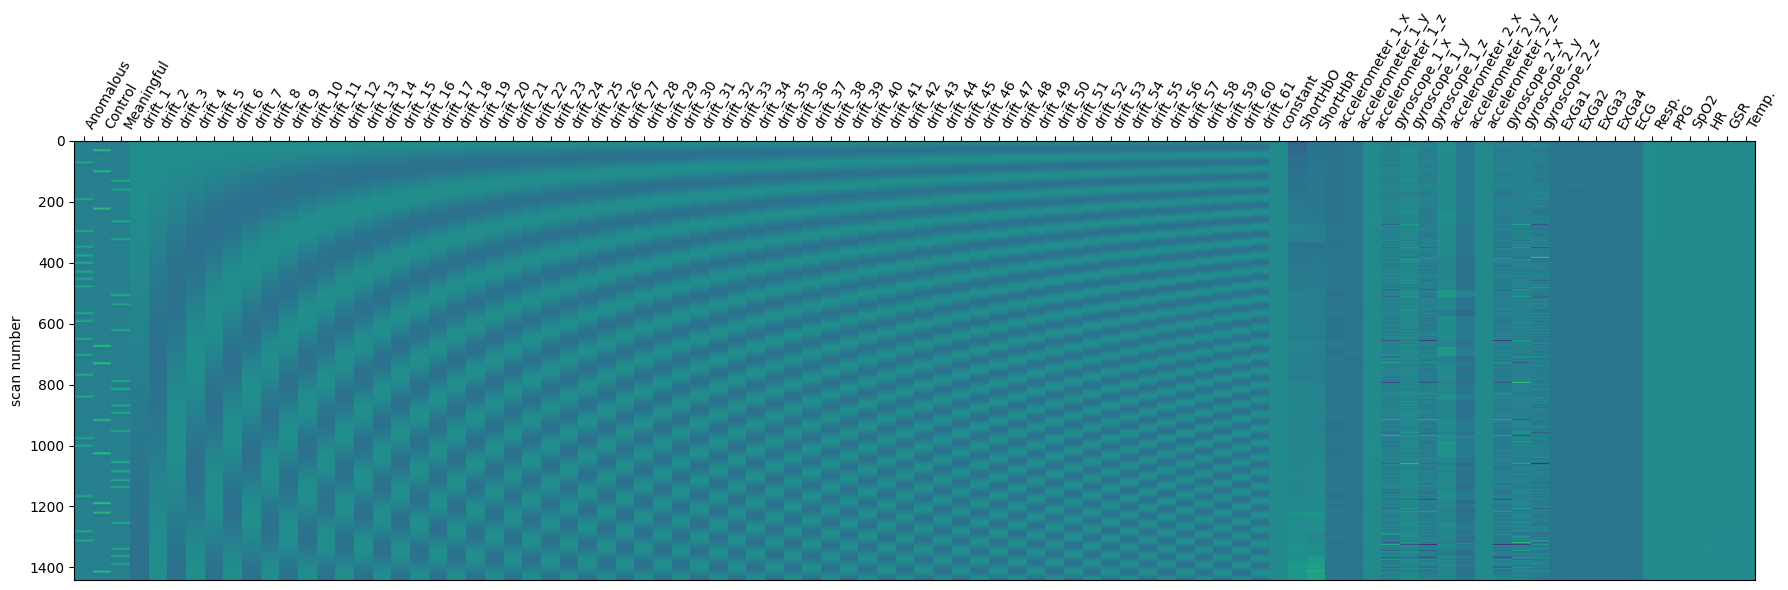

In [ ]:
fig, ax1 = plt.subplots(figsize=(18, 6), nrows=1, ncols=1)  # Create a figure with a single subplot
fig = plot_design_matrix(design_matrix, ax=ax1)  # Plot the design matrix using the specified subplot
plt.show()  # Show the plot

Expected Response Boxcar

Used Annotations descriptions: ['Anomalous', 'Control', 'Meaningful']


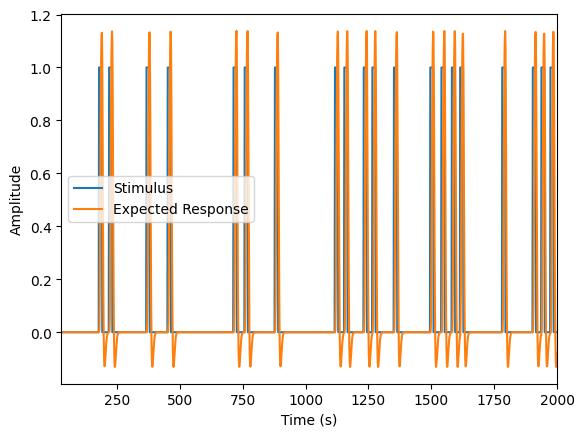

In [ ]:
s = mne_nirs.experimental_design.create_boxcar(raw_intensity, stim_dur=12.5)  # Create a boxcar function representing the expected response based on the stimulus duration
plt.plot(raw_intensity.times, s[:, 2])  # Plot the expected response for a specific condition (change the index to correspond to the condition order: 0 for Audio, 1 for Control, or 2 for Video)
plt.plot(design_matrix['Meaningful'])  # Plot the actual response from the design matrix for the corresponding condition
plt.xlim(30, 2000)  # Set the x-axis limits for the plot
plt.legend(["Stimulus", "Expected Response"])  # Add a legend to the plot
plt.xlabel("Time (s)")  # Set the x-axis label
plt.ylabel("Amplitude")  # Set the y-axis label
plt.show()  # Show the plot

Visualize WINGS Auxilary Signals

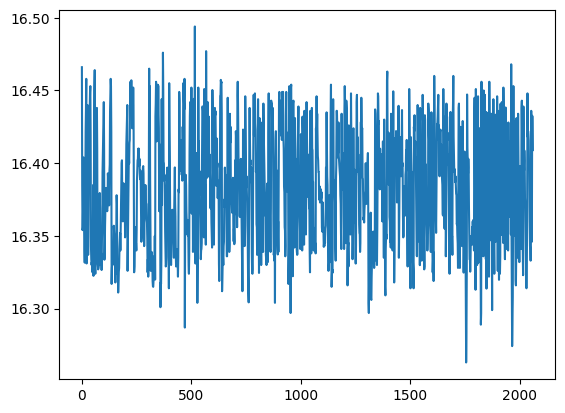

In [ ]:
# Select one auxiliary signal to visualize
n = 19  # Change the number depending on which signal you want to plot (1-23, see above)
aux = np.array(dat.get(f'nirs/aux{n}/dataTimeSeries'))  # Get the auxiliary signal data from the specified index
aux_time = np.array(dat.get(f'nirs/aux{n}/time'))  # Get the time values for the auxiliary signal
aux_data_interp = interpolate.interp1d(aux_time, aux, axis=0, bounds_error=False, fill_value='extrapolate')  # Interpolate the auxiliary signal data to match the NIRS samples
aux_data_matched_to_fnirs_single = aux_data_interp(raw_intensity.times)  # Match the auxiliary signal data to the NIRS samples
plt.plot(raw_intensity.times, aux_data_matched_to_fnirs_single)  # Plot the matched auxiliary signal data against time
plt.show()  # Show the plot

Event Timing Boxcar

Used Annotations descriptions: ['Anomalous', 'Control', 'Meaningful']


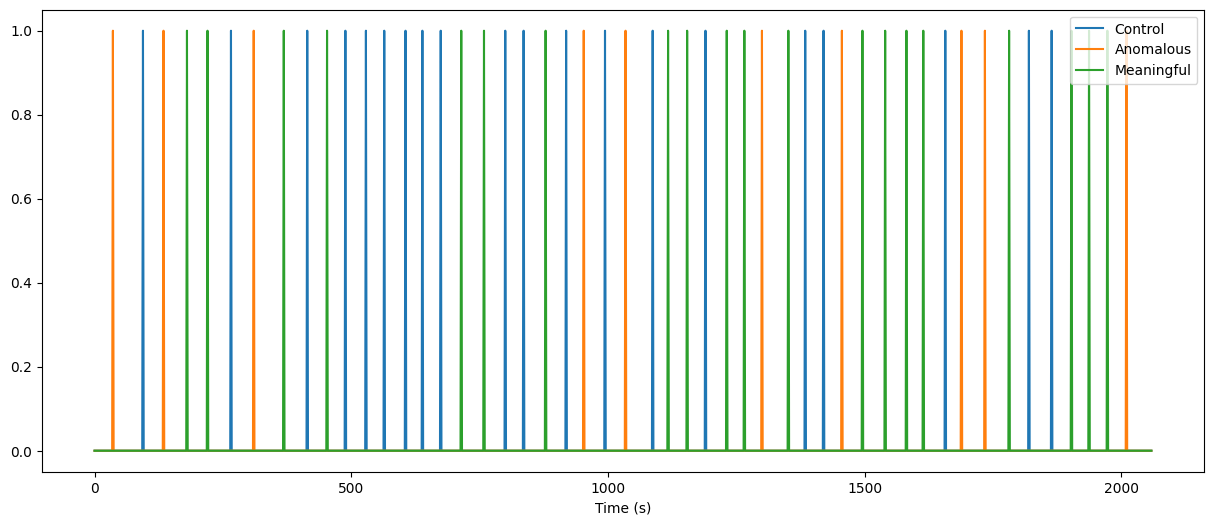

In [ ]:
s = mne_nirs.experimental_design.create_boxcar(raw_haemo)  # Create a boxcar function representing the events in the NIRS data
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))  # Create a subplot figure with a single set of axes
plt.plot(raw_haemo.times, s, axes=axes)  # Plot the boxcar function against time using the NIRS data times as the x-axis
plt.legend(cond_list, loc="upper right")  # Add a legend to the plot to label the conditions (using cond_list)
plt.xlabel("Time (s)")  # Set the x-axis label
plt.show()  # Show the plot